# Polygenic score (PGS) analysis 

This notebook calculates polygenic scores (PGS) using genotype data from VCF files generated from the ag-vampir amplicon sequencing panel. The workflow includes reading and processing VCF files, filtering SNPs based on missingness and minor allele frequency (MAF), performing association tests using generalized linear models (GLMs), and calculating polygenic scores for individual samples. Additionally, the notebook includes functions for pruning SNPs in linkage disequilibrium (LD) and visualizing the results. The analysis is tailored for a specific dataset from Siaya, but the functions are modular and can be adapted for other datasets. The goal is to identify genetic variants associated with a phenotype of interest and compute a polygenic score for insecticide resistance.

In [68]:
import pandas as pd
import numpy as np
import allel
import plotly.express as px


def _print_filter_stats(stage_label, total_snps, miss_mask, maf_mask, max_missing_filter, min_maf_filter, extra_removed=None):
    """Consistent SNP filtering report for any stage."""
    final_mask = miss_mask & maf_mask
    removed_missing = int((~miss_mask).sum())
    removed_maf = int((~maf_mask).sum())
    removed_overall = int((~final_mask).sum())
    max_missing_pct = max_missing_filter * 100
    min_maf_threshold = min_maf_filter

    print(f"SNP filtering stats ({stage_label}):")
    print(f"Total SNPs evaluated: {int(total_snps)}")
    if extra_removed is not None:
        print(f"Removed before MAF/missingness (non-segregating): {int(extra_removed)}")
    print(f"Removed for missingness (>{max_missing_pct}%): {removed_missing}")
    print(f"Removed for low MAF (<={min_maf_threshold}): {removed_maf}")
    print(f"Removed overall (failed either filter): {removed_overall}")
    print(f"SNPs retained after filtering: {int(final_mask.sum())}")


def vcf_to_glm_data(vcf_path, df_samples, sample_query='sample_id.str.contains("Siaya")', max_missing_filter=0.20, min_maf_filter=0.02, split_multiallelic=True, convert_genotypes=True):
    """
    Process a VCF file and prepare genotype data for GLM analysis.

    Parameters:
    vcf_path : str
        Path to the VCF file.
    df_samples : pd.DataFrame
        DataFrame containing sample metadata, including sample IDs and locations.
    max_missing_filter : float, optional
        Maximum allowed proportion of missing genotypes per SNP (default is 0.20).
    min_maf_filter : float, optional
        Minimum minor allele frequency (MAF) threshold for filtering SNPs (default is 0.02).
    split_multiallelic : bool, optional
        Whether to split multiallelic SNPs into separate rows (default is True).
    convert_genotypes : bool, optional
        Whether to convert genotypes to alternate allele counts (0, 1, 2) (default is True).

    Returns:
    pd.DataFrame
        A DataFrame containing processed genotype data, with SNPs as columns and samples as rows.
    """
    vcf_df = vcf_to_df(
        vcf_path,
        df_samples,
        sample_query=sample_query,
        max_missing_filter=max_missing_filter,
        min_maf_filter=min_maf_filter,
    )
    samples = vcf_df.columns[6:]

    if split_multiallelic:
        vcf_df = split_rows_with_multiple_alleles(vcf_df, samples)

    if convert_genotypes:
        vcf_df = convert_genotype_to_alt_allele_count(vcf_df, samples)

    vcf_df = vcf_df.assign(
        snp_id=lambda x: "snp_" + x.CHROM.astype(str) + ":" + x.POS.astype(str) + "_" + x.REF.astype(str) + ">" + x.ALT.astype(str)
    )

    vcf_df = apply_final_snp_filters(
        vcf_df,
        samples=samples,
        max_missing_filter=max_missing_filter,
        min_maf_filter=min_maf_filter,
        genotypes_are_alt_counts=convert_genotypes,
    )

    vcf_df = vcf_df.set_index('snp_id')
    vcf_df = vcf_df.drop(columns=['CHROM', 'POS', 'FILTER_PASS', 'REF', 'ALT', 'ANN']).T
    vcf_df = pd.concat([df_samples.set_index('sample_id').query(sample_query, engine='python'), vcf_df], axis=1)

    return vcf_df


def vcf_to_df(vcf_path, df_samples, sample_query, max_missing_filter=0.20, min_maf_filter=0.02, query2=None):
    """Read VCF, subset samples, and apply initial SNP filtering for performance."""
    vcf_dict = allel.read_vcf(vcf_path, fields='*')
    samples = vcf_dict['samples']
    contig = vcf_dict['variants/CHROM']
    pos = vcf_dict['variants/POS']
    filter_pass = vcf_dict['variants/FILTER_PASS']
    ref = vcf_dict['variants/REF']
    alt = [','.join([a for a in row if a != '']) for row in vcf_dict['variants/ALT']]
    alt = np.array(alt, dtype=object)
    ann = vcf_dict['variants/ANN']
    geno = allel.GenotypeArray(vcf_dict['calldata/GT'])

    print(f"Initial number of samples: {len(samples)}")
    print(f"Initial number of SNPs: {geno.shape[0]}")

    mask = df_samples.eval(sample_query, engine='python')
    sample_mask = np.isin(samples, df_samples[mask].sample_id)

    geno = geno.compress(sample_mask, axis=1)
    samples = samples[sample_mask]

    if query2 is not None:
        mask = df_samples.eval(query2, engine='python')
        geno = geno.compress(mask, axis=1)
        samples = samples[mask]

    print(f"Final number of samples after sample filtering: {len(samples)}")

    ac = geno.count_alleles(max_allele=3)
    seg_mask = ac.is_segregating()

    geno_seg = geno.compress(seg_mask, axis=0)
    ac_seg = geno_seg.count_alleles(max_allele=3)

    miss_mask = geno_seg.is_missing().mean(axis=1) <= max_missing_filter
    maf = np.minimum(ac_seg.to_frequencies()[:, 1:].sum(axis=1), 1 - ac_seg.to_frequencies()[:, 1:].sum(axis=1))
    maf_mask = maf > min_maf_filter

    _print_filter_stats(
        stage_label='initial pre-split',
        total_snps=len(geno_seg),
        miss_mask=miss_mask,
        maf_mask=maf_mask,
        max_missing_filter=max_missing_filter,
        min_maf_filter=min_maf_filter,
        extra_removed=int((~seg_mask).sum()),
    )

    keep_mask_seg = miss_mask & maf_mask

    geno_final = geno_seg.compress(keep_mask_seg, axis=0)
    contig_final = contig[seg_mask][keep_mask_seg]
    pos_final = pos[seg_mask][keep_mask_seg]
    filter_pass_final = filter_pass[seg_mask][keep_mask_seg]
    ref_final = ref[seg_mask][keep_mask_seg]
    alt_final = alt[seg_mask][keep_mask_seg]
    ann_final = ann[seg_mask][keep_mask_seg]

    vcf_df = pd.DataFrame(
        {
            'CHROM': contig_final,
            'POS': pos_final,
            'FILTER_PASS': filter_pass_final,
            'REF': ref_final,
            'ALT': alt_final,
            'ANN': ann_final,
        }
    )
    geno_df = pd.DataFrame(geno_final.to_gt().astype(str), columns=samples)
    vcf = pd.concat([vcf_df, geno_df], axis=1)

    print(f"Final DataFrame shape after initial filtering: {vcf.shape}")

    return vcf


def apply_final_snp_filters(vcf_df, samples, max_missing_filter=0.20, min_maf_filter=0.02, genotypes_are_alt_counts=True):
    """Apply post-split/post-encoding SNP-level missingness and MAF filters."""
    geno_df = vcf_df[samples].copy()

    if not genotypes_are_alt_counts:
        geno_df = geno_df.applymap(
            lambda gt: np.nan if pd.isna(gt) or gt == './.' else sum(allele != '0' for allele in str(gt).split('/'))
        )

    geno_df = geno_df.apply(pd.to_numeric, errors='coerce')

    missing_frac = geno_df.isna().mean(axis=1)
    miss_mask = missing_frac <= max_missing_filter

    called_n = geno_df.notna().sum(axis=1)
    alt_count = geno_df.sum(axis=1, skipna=True)
    denom = 2 * called_n

    alt_freq = pd.Series(np.nan, index=geno_df.index, dtype=float)
    valid = denom > 0
    alt_freq.loc[valid] = alt_count.loc[valid] / denom.loc[valid]

    maf = pd.Series(np.nan, index=geno_df.index, dtype=float)
    maf.loc[valid] = np.minimum(alt_freq.loc[valid], 1 - alt_freq.loc[valid])
    maf_mask = maf > min_maf_filter

    _print_filter_stats(
        stage_label='final post-split',
        total_snps=len(vcf_df),
        miss_mask=miss_mask,
        maf_mask=maf_mask,
        max_missing_filter=max_missing_filter,
        min_maf_filter=min_maf_filter,
        extra_removed=None,
    )

    final_mask = miss_mask & maf_mask
    return vcf_df.loc[final_mask].copy()


def split_rows_with_multiple_alleles(df, samples):
    # Create an empty list to store the new rows
    new_rows = []
    # Iterate through each row
    for index, row in df.iterrows():
        alt_alleles = row['ALT'].split(',')
        # Check if there are multiple alleles in the ALT field
        if len(alt_alleles) > 1:
            for allele_num, allele in enumerate(alt_alleles):
                # Create a new row for each allele
                new_row = row.copy()
                new_row['ALT'] = allele
                # Update genotype fields
                for col in samples:
                    genotype = row[col]
                    # Split the genotype and process it
                    if genotype != './.':
                        gt_alleles = genotype.split('/')
                        new_gt = ['0' if (int(gt) != allele_num + 1 and gt != '0') else gt for gt in gt_alleles]
                        new_row[col] = '/'.join(new_gt)
                new_rows.append(new_row)
        else:
            new_rows.append(row)

    new_df = pd.DataFrame(new_rows).reset_index(drop=True)
    return new_df


def convert_genotype_to_alt_allele_count(df, samples):
    """
    Convert genotype data to alternate allele counts (0, 1, or 2).

    Parameters:
    df : pd.DataFrame
        DataFrame containing genotype data, with genotypes in the format '0/0', '0/1', etc.
    samples : list
        List of sample IDs corresponding to genotype columns in the DataFrame.

    Returns:
    pd.DataFrame
        A DataFrame with genotypes converted to alternate allele counts.
    """
    nalt_df = df.copy()
    # Iterate through each row
    for index, row in df.iterrows():
        # Update genotype fields
        for col in samples:
            genotype = row[col]
            if genotype != './.':
                # Split the genotype and count non-zero alleles
                alleles = genotype.split('/')
                alt_allele_count = sum([1 for allele in alleles if allele != '0'])
                nalt_df.at[index, col] = alt_allele_count
            else:
                nalt_df.at[index, col] = np.nan

    return nalt_df



#### Code -  run GLM and process results

In [ ]:
def calculate_pseudo_r2(results):
    """
    Calculate different pseudo R² measures for a fitted GLM model
    
    Parameters:
    results : statsmodels GLMResults object
        The fitted model results
        
    Returns:
    dict : Dictionary containing different pseudo R² measures
    """
    ll_null = results.null_deviance / -2
    ll_model = results.deviance / -2
    n = results.nobs
    
    r2_mcfadden = 1 - (ll_model / ll_null)
    r2_coxsnell = 1 - np.exp((2/n) * (ll_null - ll_model))
    r2_nagelkerke = r2_coxsnell / (1 - np.exp((2/n) * ll_null))
    
    return {
        'McFadden R²': r2_mcfadden,
        'Nagelkerke R²': r2_nagelkerke
    }

def glm_all_snps(snp_df):
    import statsmodels.formula.api as smf
    import statsmodels.api as sm
    from statsmodels.stats.multitest import fdrcorrection
    
    dfs = []
    for snp in snp_df.filter(like="snp_").columns:
        glm_data = snp_df[['phenotype', snp]].dropna()
        glm_data[snp] = glm_data[snp].astype(int)
        glm_data.columns = ['phenotype', 'snp']
    
        # df_contingency = pd.crosstab(glm_data['phenotype'], glm_data['snp'])
        
        formula = f'phenotype ~ snp'
        logit_model = smf.glm(formula=formula, data=glm_data, family=sm.families.Binomial())
        log_results = logit_model.fit()
        
        # Calculate pseudo R² measures
        r2_values = calculate_pseudo_r2(log_results)
    
        pval_data = results_summary_to_dataframe(log_results)
        # Add R² values to the results
        for r2_name, r2_value in r2_values.items():
            pval_data[r2_name] = r2_value
            
        dfs.append(pval_data.assign(snp=snp))
        
    df_eff = pd.concat(dfs).query("index != 'Intercept'")
    res = fdrcorrection(df_eff['pvals'], alpha=0.05)
    df_eff['fdr'] = res[1]
    df_eff['fdr_sig'] = res[0]
    return process_effect_sizes(df_eff)


def process_effect_sizes(df_eff):
    """Validate, annotate, and index per-SNP GLM effect sizes for downstream LD pruning/PGS."""
    # We expect one modeled row per SNP at this stage.
    assert 'snp' in df_eff.columns, "Expected 'snp' column in effect size dataframe."
    assert df_eff['snp'].is_unique, "Expected one GLM result per SNP; found duplicate SNP IDs before annotation merge."

    # Parse SNP IDs (e.g. snp_2L:12345_A>G) back into merge keys.
    parsed = df_eff['snp'].str.extract(r"^snp_(?P<CHROM>[^:]+):(?P<POS>\d+)_(?P<REF>[^>]+)>(?P<ALT>.+)$")
    assert parsed.notna().all().all(), (
        "Unable to parse one or more SNP IDs. Expected format: snp_<CHROM>:<POS>_<REF>><ALT>."
    )

    # Attach parsed keys to effect-size rows.
    df_eff = pd.concat([df_eff, parsed], axis=1)
    df_eff['POS'] = df_eff['POS'].astype(int)

    # Ensure the annotation table has the columns needed to reconstruct SNP IDs.
    required_ann_cols = {'CHROM', 'POS', 'REF', 'ALT', 'ANN'}
    missing_ann_cols = required_ann_cols.difference(snp_data.columns)
    assert not missing_ann_cols, f"snp_data is missing required columns: {sorted(missing_ann_cols)}"

    # Build annotation SNP IDs using the same convention as GLM results.
    ann_df = snp_data[list(required_ann_cols)].copy()
    ann_df = ann_df.assign(
        snp=lambda x: "snp_" + x.CHROM.astype(str) + ":" + x.POS.astype(int).astype(str) + "_" + x.REF.astype(str) + ">" + x.ALT.astype(str)
    )

    # Guard against ambiguous annotation lookups.
    duplicate_ann = ann_df['snp'].duplicated(keep=False)
    assert not duplicate_ann.any(), (
        "Annotation table contains duplicate SNP IDs even after using CHROM+POS+REF+ALT. "
        f"Example duplicates: {ann_df.loc[duplicate_ann, 'snp'].head(5).tolist()}"
    )

    # Merge ANN onto effect sizes and verify it is strictly one-to-one.
    pre_merge_rows = len(df_eff)
    df_eff = df_eff.merge(
        ann_df[['snp', 'ANN']],
        on='snp',
        how='left',
        validate='one_to_one'
    )
    assert len(df_eff) == pre_merge_rows, "Annotation merge changed row count unexpectedly."

    # Fail fast if any scored SNP lacks annotation.
    missing_ann = df_eff['ANN'].isna()
    assert not missing_ann.any(), (
        "Missing annotation for one or more SNPs after merge. "
        f"Example SNPs: {df_eff.loc[missing_ann, 'snp'].head(5).tolist()}"
    )

    # Final shape for downstream functions: SNP ID index + effect/annotation columns.
    cols = ['snp'] + [col for col in df_eff.columns if col != 'snp']
    df_eff = df_eff[cols].drop(columns=['CHROM', 'POS', 'REF', 'ALT'])
    df_eff = df_eff.set_index('snp')
    assert df_eff.index.is_unique, "Effect size index must be unique before LD pruning."
    return df_eff


def results_summary_to_dataframe(results):
    '''take the result of an statsmodel results table and transforms it into a dataframe'''
    pvals = results.pvalues
    coeff = results.params
    conf_lower = results.conf_int()[0]
    conf_higher = results.conf_int()[1]

    results_df = pd.DataFrame({"pvals":pvals,
                               "odds_ratio":np.exp(coeff),
                               "conf_lower":np.exp(conf_lower),
                               "conf_higher":np.exp(conf_higher)
                                })
    
    results_df.loc[:, 'sig'] = [True if pval <= 0.05 else False for pval in pvals]
    results_df = results_df[["odds_ratio","pvals","conf_lower","conf_higher", "sig"]]
    return results_df

#### Code - compute correlations and select snps

In [70]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def compute_snp_correlations(df, correlation_threshold=0.5):
    corr_matrix = df.corr()
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
   
    high_corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) > correlation_threshold:
                high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))
    
    print(f"Total SNPs analyzed: {len(df.columns)}")
    print(f"Number of highly correlated SNP pairs (|r| > {correlation_threshold}): {len(high_corr_pairs)}")
    
    return corr_matrix, high_corr_pairs

def plot_correlation_heatmap(corr_matrix):
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1, center=0)
    plt.title('SNP Correlation Heatmap')
    plt.show()

def select_representative_snps(df, high_corr_pairs):
    assert df.index.is_unique, "Effect size dataframe index must be unique before SNP selection."

    to_remove = set()
    pos_corr_removed = 0
    neg_corr_removed = 0

    for snp1, snp2, corr in high_corr_pairs:
        if snp1 not in to_remove and snp2 not in to_remove:
            if corr < 0:  # Negative correlation
                if df.at[snp1, 'odds_ratio'] < 1:
                    to_remove.add(snp1)
                    neg_corr_removed += 1
                elif df.at[snp2, 'odds_ratio'] < 1:
                    to_remove.add(snp2)
                    neg_corr_removed += 1
                else:
                    if df.at[snp1, 'fdr'] < df.at[snp2, 'fdr']:
                        to_remove.add(snp2)
                        neg_corr_removed += 1
                    else:
                        to_remove.add(snp1)
                        neg_corr_removed += 1
            else:  # Positive correlation
                if df.at[snp1, 'fdr'] < df.at[snp2, 'fdr']:
                    to_remove.add(snp2)
                    pos_corr_removed += 1
                else:
                    to_remove.add(snp1)
                    pos_corr_removed += 1

    selected_snps = np.array(list(set(df.index) - to_remove))

    print(f"Total SNPs before selection: {len(df)}")
    print(f"SNPs removed due to positive correlation: {pos_corr_removed}")
    print(f"SNPs removed due to negative correlation: {neg_corr_removed}")
    print(f"Total SNPs removed: {len(to_remove)}")
    print(f"SNPs retained after selection: {len(selected_snps)}")

    return selected_snps


def linked(df_genos, df_eff, correlation_threshold=0.5):
    genotype_snps = df_genos.filter(like='snp_')
    assert genotype_snps.columns.is_unique, "Genotype dataframe has duplicate SNP columns."
    assert df_eff.index.is_unique, "Effect size dataframe index must be unique before correlation pruning."

    missing_in_eff = set(genotype_snps.columns) - set(df_eff.index)
    assert not missing_in_eff, (
        "Some genotype SNPs are missing from the effect size table. "
        f"Example missing SNPs: {list(sorted(missing_in_eff))[:5]}"
    )

    corr_matrix, high_corr_pairs = compute_snp_correlations(genotype_snps, correlation_threshold)
    plot_correlation_heatmap(corr_matrix)
    selected_snps = select_representative_snps(df_eff, high_corr_pairs)
    return np.sort(selected_snps)


In [71]:
df_amp_samples = pd.read_csv("./data/metadata.qcpass.tsv", sep="\t")
df_amp_samples = df_amp_samples.assign(phenotype=df_amp_samples.sample_id.str.extract(r'_(Dead|Alive)_'))
df_amp_samples = df_amp_samples.rename(columns={'sampleID':'sample_id'})

In [72]:
df_amp_samples.shape

(785, 16)

### Perform association tests with separate binomial GLMs

In [6]:
# load snp dataframe for snp annotations 
snp_data = pd.read_excel("./data/natcomms-snps.xlsx")

In [73]:
snp_data.head(2)

,CHROM,POS,FILTER_PASS,REF,ALT,ANN,G1,G9,G17,G25,...,Siaya_Delta_Alive_126,Siaya_Delta_Dead_128,Siaya_Delta_Dead_129,Siaya_Delta_Dead_130,Siaya_Delta_Dead_131,Siaya_Delta_Alive_127,Siaya_Delta_Alive_128,Siaya_Delta_Alive_129,Siaya_Delta_Alive_130,Siaya_Delta_Alive_131
0,2L,209500,False,T,C,C|synonymous_variant|LOW|AGAP004679|AGAP004679...,NaN,0.0,NaN,NaN,...,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2L,209503,False,A,T,T|stop_gained|HIGH|AGAP004679|AGAP004679|trans...,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [77]:
import warnings 
warnings.filterwarnings("ignore", category=RuntimeWarning, module="pandas.core.arraylike")
warnings.filterwarnings("ignore", category=UserWarning, module="allel.io")

df_genos = {}
df_effs = {}
# methods = ['targets', 'amplicons']
methods  =  ['amplicons']
for method in methods:
    df_genos[method] = vcf_to_glm_data(
        vcf_path=f"./data/natcomms.annot.vcf", 
        df_samples=df_amp_samples, 
        sample_query='sample_id.str.contains("Siaya")',
        min_maf_filter=0.02, 
        max_missing_filter=0.20
    )
    print("\n")

    # run a glm on each snp on the input data 
    df_effs[method] = glm_all_snps(df_genos[method])
    df_effs[method].to_csv(f"glm-siaya-effect-size-{method}.csv")

Initial number of samples: 933
Initial number of SNPs: 193719
Final number of samples after sample filtering: 247
SNP filtering stats (initial pre-split):
Total SNPs evaluated: 1849
Removed before MAF/missingness (non-segregating): 191870
Removed for missingness (>20.0%): 625
Removed for low MAF (<=0.02): 1281
Removed overall (failed either filter): 1670
SNPs retained after filtering: 179
Final DataFrame shape after initial filtering: (179, 253)
SNP filtering stats (final post-split):
Total SNPs evaluated: 248
Removed for missingness (>20.0%): 0
Removed for low MAF (<=0.02): 69
Removed overall (failed either filter): 69
SNPs retained after filtering: 179




### Compute correlations between snps and prune snps in LD

Total SNPs analyzed: 179
Number of highly correlated SNP pairs (|r| > 0.5): 788


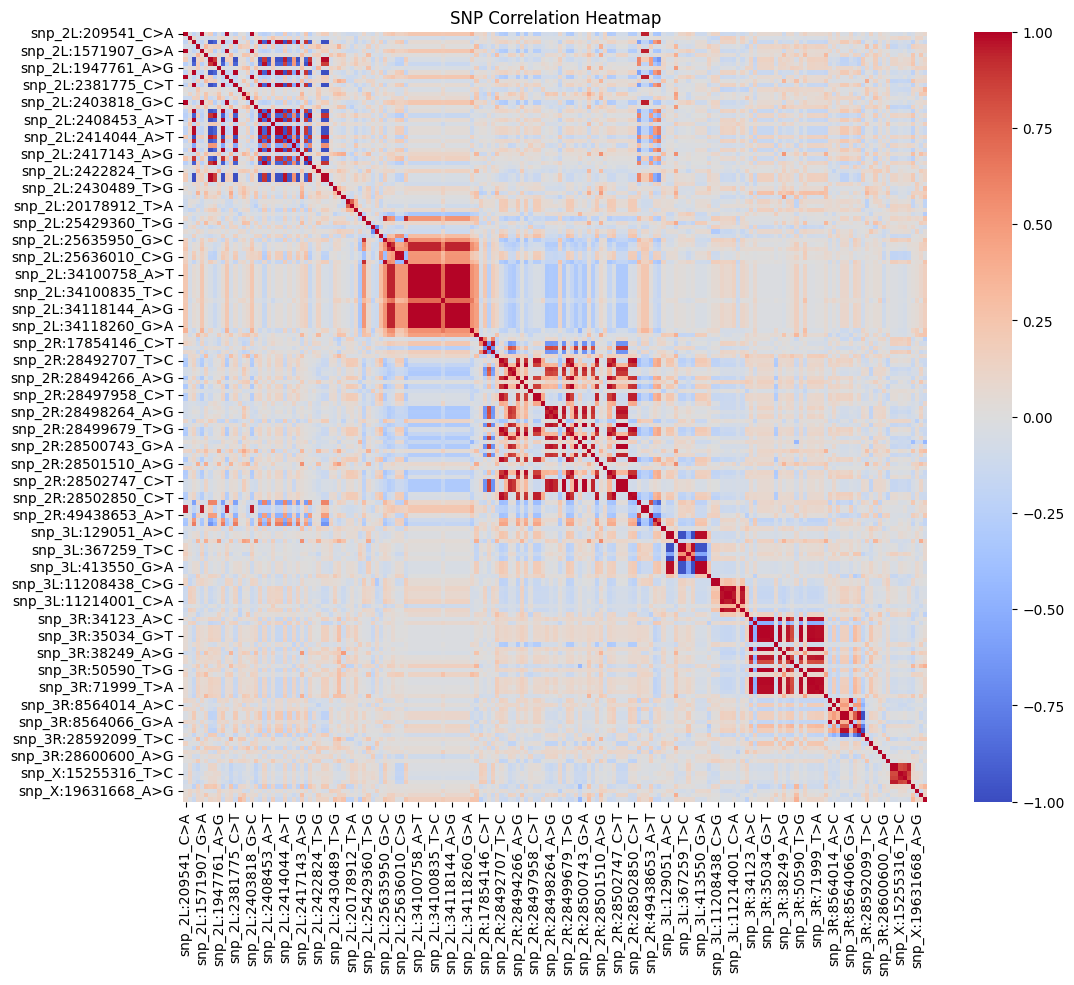

Total SNPs before selection: 179
SNPs removed due to positive correlation: 95
SNPs removed due to negative correlation: 19
Total SNPs removed: 114
SNPs retained after selection: 65


In [78]:
selected_snps = {}
for method in methods:
    selected_snps[method] = linked(df_genos[method].filter(like='snp_').dropna().astype(int), df_effs[method])

## Calculating PGS

*PGS = Σ(βi * Xi)*

Where:
- PGS is the Polygenic Score
- Σ represents the sum over all considered SNPs
- βi is the effect size (log odds) of the i-th SNP
- Xi is the number of risk alleles (0, 1, or 2) for the i-th SNP in an individual

In [138]:
def calculate_pgs(
    df_genos,
    df_effs,
    selected_snps,
    df_amp_samples,
    method,
    sig_only=False,
    standardize=True,
):
    """
    Calculate PRS on the GLM cohort using LD-pruned selected SNPs for a method.

    Required inputs:
    - df_genos: dict of genotype dataframes keyed by method
    - df_effs: dict of effect-size dataframes keyed by method
    - selected_snps: dict of selected SNP arrays keyed by method
    - df_amp_samples: sample metadata dataframe
    - method: key selecting which method to score
    """
    assert method in df_genos, f"Method '{method}' not found in df_genos."
    assert method in df_effs, f"Method '{method}' not found in df_effs."
    assert method in selected_snps, f"Method '{method}' not found in selected_snps."

    selected = list(selected_snps[method])
    assert len(selected) > 0, f"No selected SNPs available for method '{method}'."

    df_snp = df_genos[method].filter(like='snp_')
    df_eff = df_effs[method]

    missing_selected = set(selected) - set(df_snp.columns)
    assert not missing_selected, (
        "Selected SNPs are missing in genotype matrix. "
        f"Example: {list(sorted(missing_selected))[:5]}"
    )

    missing_effects = set(selected) - set(df_eff.index)
    assert not missing_effects, (
        "Selected SNPs are missing in effect-size table. "
        f"Example: {list(sorted(missing_effects))[:5]}"
    )

    # keep selected SNPs only, preserving selected_snps order
    df_snp = df_snp[selected]
    df_eff = df_eff.loc[selected]

    assert df_snp.columns.is_unique, "SNP genotype columns must be unique."
    assert df_eff.index.is_unique, "Effect size index must be unique."

    # align and reorder effects to match genotype columns exactly
    df_eff = df_eff.loc[df_snp.columns]

    # Avoid pandas silent downcasting warnings by enforcing numeric dtype before imputation.
    df_snp = df_snp.apply(pd.to_numeric, errors='coerce')
    df_snp = df_snp.fillna(df_snp.median(numeric_only=True))

    if sig_only:
        sig_selected = df_eff.query("sig == True").index.tolist()
        assert len(sig_selected) > 0, "No significant SNPs found with sig_only=True."
        df_snp = df_snp[sig_selected]
        df_eff = df_eff.loc[sig_selected]

    assert np.isfinite(df_eff.odds_ratio).all(), "Found non-finite odds ratios."
    assert (df_eff.odds_ratio > 0).all(), "Odds ratios must be strictly positive to compute log(OR)."

    pgs = _calculate_pgs(
        genotypes=df_snp.T.values,
        odds_ratios=df_eff.odds_ratio,
        standardize=standardize,
    )

    pgs_df = pd.DataFrame({'sample_id': df_snp.index, 'pgs': pgs})
    pgs_df = pgs_df.merge(df_amp_samples, on='sample_id', how='left')
    pgs_df = pgs_df.assign(method=method, n_selected_snps=len(selected))

    return pgs_df


def _calculate_pgs(genotypes, odds_ratios, standardize=False):
    """
    genotypes: 2D array (n_snps, n_samples) of alt-allele counts (0,1,2)
    odds_ratios: 1D array (n_snps,)
    """
    odds_ratios = np.asarray(odds_ratios).flatten()
    betas = np.log(odds_ratios)
    pgs = (genotypes * betas[:, None]).sum(axis=0)

    if standardize:
        pgs = (pgs - pgs.mean()) / pgs.std(ddof=0)

    return pgs



In [140]:
# PRS on the discovery cohort itself (subset to LD-pruned selected_snps)
pgs_discovery = {}
for method in methods:
    pgs_discovery[method] = calculate_pgs(
        df_genos=df_genos,
        df_effs=df_effs,
        selected_snps=selected_snps,
        df_amp_samples=df_amp_samples,
        method=method,
        sig_only=False,
        standardize=True,
    )

    print(f"{method}: calculated PRS for {len(pgs_discovery[method])} samples using {pgs_discovery[method]['n_selected_snps'].iloc[0]} selected SNPs")

amplicons: calculated PRS for 247 samples using 65 selected SNPs


### PGS scores for genotyped LLINEUP data

We have many samples which were genotyped at ~5 loci using conventional qPCR assays. There is more samples than were whole genome sequenced. 

In [144]:
df_ento = pd.read_csv("./llineup_ento.csv").query("MolSpecies == 'S'").reset_index(drop=True)
df_geno = df_ento[['kdr', 'Cyp4J5', 'Coeaed1', 'Cyp6P4']]

df_geno = df_geno.assign(kdr_f=lambda x: x.kdr,
               kdr_s=lambda x: x.kdr).drop(columns='kdr')

def genotype_to_numeric_resistant(genotype, resistant_allele):
    """
    Encode alleles as 1 if they are the resistant allele, 0 otherwise.
    Returns shape (2,) with np.nan if missing.
    """
    if pd.isna(genotype):
        return np.array([np.nan, np.nan], dtype=float)

    # Normalize possible genotype formats
    # - tuple/list like ('F','S')
    # - string like "FS" or "F/S"
    if isinstance(genotype, str):
        gt = genotype.replace("/", "").replace("|", "").strip()
        alleles = list(gt)
    else:
        alleles = list(genotype)

    if len(alleles) != 2:
        # Fallback: pad/truncate to diploid expectation
        alleles = (alleles + [np.nan, np.nan])[:2]

    return np.array([int(allele == resistant_allele) if not pd.isna(allele) else np.nan
                     for allele in alleles], dtype=float)

def convert_genotypes_to_3d_array(df, snp_columns, resistant_alleles):
    n_snps = len(snp_columns)
    n_samples = df.shape[0]
    n_ploidy = 2  # diploid
    genotype_array = np.zeros((n_snps, n_samples, n_ploidy), dtype=float)

    for i, (column, r_allele) in enumerate(zip(snp_columns, resistant_alleles)):
        genotype_array[i] = np.array(
            [genotype_to_numeric_resistant(gt, r_allele) for gt in df[column]],
            dtype=float
        )

    return genotype_array


def summarize_missing_calls(genotype_array, label='LLINEUP'):
    """
    Summarize missing genotype-call counts per sample.
    genotype_array shape: (n_snps, n_samples, ploidy)
    A SNP call is considered missing for a sample if any allele is missing.
    """
    missing_calls_per_sample = np.isnan(genotype_array).any(axis=2).sum(axis=0)
    n_samples = missing_calls_per_sample.shape[0]

    print(f"Missing genotype-call summary ({label}):")
    for k in range(5):
        pct = (missing_calls_per_sample == k).mean() * 100
        n_k = int((missing_calls_per_sample == k).sum())
        print(f"{k} missing calls: {n_k}/{n_samples} samples ({pct:.1f}%)")

    if (missing_calls_per_sample > 4).any():
        n_over = int((missing_calls_per_sample > 4).sum())
        pct_over = (missing_calls_per_sample > 4).mean() * 100
        print(f">4 missing calls: {n_over}/{n_samples} samples ({pct_over:.1f}%)")

    return missing_calls_per_sample


column_letter_pairs = [
    ('Cyp4J5', 'F', '2L:25635973_G>A'),
    ('Cyp6P4', 'M', '2R:28497967_G>C'),
    ('kdr_f', 'F', '2L:2422652_A>T'),
    ('kdr_s', 'S', '2L:2422651_T>C')
]

snp_columns = [pair[0] for pair in column_letter_pairs]
resistant_alleles = [pair[1] for pair in column_letter_pairs]
snp_positions = [pair[2] for pair in column_letter_pairs]

gn = convert_genotypes_to_3d_array(df_geno, snp_columns, resistant_alleles)
missing_calls_per_sample = summarize_missing_calls(gn, label="LLINEUP")

# If you have missing data, don't cast straight to int (NaN -> error).
# Either impute first, or keep as float until later.
# gn = allel.GenotypeArray(gn.astype(np.int8))  # only safe if no NaNs remain
# gn = allel.GenotypeArray(gn.astype(int))

Missing genotype-call summary (LLINEUP):
0 missing calls: 3080/3174 samples (97.0%)
1 missing calls: 45/3174 samples (1.4%)
2 missing calls: 2/3174 samples (0.1%)
3 missing calls: 0/3174 samples (0.0%)
4 missing calls: 47/3174 samples (1.5%)


In [145]:
snpsnp_positions = ["snp_" + s for s in snp_positions]
snpsnp_positions

['snp_2L:25635973_G>A',
 'snp_2R:28497967_G>C',
 'snp_2L:2422652_A>T',
 'snp_2L:2422651_T>C']

In [146]:
pval_df = pd.read_csv("./glm-siaya-effect-size-amplicons.csv", index_col=0)

# pval_df = df_effs['amplicons']
pval_genotyped_df = pval_df.loc[snpsnp_positions]
pval_genotyped_df.to_excel("pval_genotyped_df.xlsx")

In [147]:
def _genotype_array_to_alt_dosage_with_nan(gn):
    """
    Convert (n_snps, n_samples, ploidy) resistant-allele indicators to
    alt-allele dosage (n_snps, n_samples), preserving missing calls as NaN.
    """
    gn = np.asarray(gn, dtype=float)
    dosage = gn.sum(axis=2)
    missing_calls = np.isnan(gn).any(axis=2)
    dosage = dosage.astype(float)
    dosage[missing_calls] = np.nan
    return dosage


def _calculate_prs_with_missing_policy(genotypes, odds_ratios, standardize=False):
    """
    Missingness policy:
    - exactly 1 missing SNP call in a sample: impute that call with SNP median dosage
    - >=2 missing SNP calls in a sample: return NaN PRS for that sample
    """
    genotypes = np.asarray(genotypes, dtype=float)  # (n_snps, n_samples)
    missing_counts = np.isnan(genotypes).sum(axis=0)

    # Impute NaNs with SNP medians (samples with >=2 missing are masked to NaN later)
    snp_medians = np.nanmedian(genotypes, axis=1)
    genotypes_imputed = genotypes.copy()
    nan_rows, nan_cols = np.where(np.isnan(genotypes_imputed))
    if len(nan_rows) > 0:
        genotypes_imputed[nan_rows, nan_cols] = snp_medians[nan_rows]

    prs = _calculate_pgs(genotypes_imputed, odds_ratios, standardize=False).astype(float)
    prs[missing_counts >= 2] = np.nan

    if standardize:
        valid = np.isfinite(prs)
        if valid.any():
            mean = prs[valid].mean()
            std = prs[valid].std(ddof=0)
            if std > 0:
                prs[valid] = (prs[valid] - mean) / std
            else:
                prs[valid] = 0.0

    return prs, missing_counts


def llineup_prs(df_ento, gn, query=None, name='prs_standardised', standardize=False):
    df_ento = df_ento.copy()

    if query:
        mask = df_ento.eval(query, engine='python')
        gn = np.compress(mask.to_numpy(), gn, axis=1)
        df_ento = df_ento[mask].copy()

    n_alt = _genotype_array_to_alt_dosage_with_nan(gn)
    prs, missing_counts = _calculate_prs_with_missing_policy(
        n_alt,
        pval_genotyped_df['odds_ratio'].values,
        standardize=standardize,
    )

    n_samples = len(missing_counts)
    n_imputed = int((missing_counts == 1).sum())
    n_nan_prs = int((missing_counts >= 2).sum())
    print(f"PRS missingness policy: imputed 1 missing call for {n_imputed}/{n_samples} samples; set {n_nan_prs}/{n_samples} samples to NaN PRS (>=2 missing calls).")

    df_ento.loc[:, name] = prs
    prs_per_hsd = df_ento.groupby('HSD').agg({name: ['mean', 'std', 'count']})

    return df_ento, prs_per_hsd



In [148]:
df_ento_prs, prs_per_hsd = llineup_prs(df_ento, gn, query=None, name='prs', standardize=False)

df_ento_prs_norm, prs_norm_per_hsd = llineup_prs(df_ento, gn, query=None, name='prs', standardize=True)

PRS missingness policy: imputed 1 missing call for 45/3174 samples; set 49/3174 samples to NaN PRS (>=2 missing calls).
PRS missingness policy: imputed 1 missing call for 45/3174 samples; set 49/3174 samples to NaN PRS (>=2 missing calls).


In [149]:
px.histogram(prs_per_hsd['prs']['mean'],  template='simple_white',  width=500, height=300)

### Write out RND 1 and east samples to .csv 

We are restricting analysis to baseline and eastern samples.

In [150]:
df_ento_prs.to_csv("df_ento_prs.csv", index=False)

In [151]:
df_ento_prs.sort_values('prs', ascending=False).head(10)[['kdr', 'Cyp4J5', 'Cyp6P4', 'prs']]

,kdr,Cyp4J5,Cyp6P4,prs
1559,FF,FF,MM,5.486692
3034,FF,FF,MM,5.486692
1261,FF,FF,MM,5.486692
2919,FF,FF,MM,5.486692
2063,FF,FF,MM,5.486692
3070,FF,FF,MM,5.486692
3063,FF,FF,MM,5.486692
3059,FF,FF,MM,5.486692
3053,FF,FF,MM,5.486692
3047,FF,FF,MM,5.486692


In [152]:
df_ento_prs[['kdr', 'Cyp4J5', 'Cyp6P4', 'prs']].dropna().sort_values('prs')

,kdr,Cyp4J5,Cyp6P4,prs
2630,SS,LL,II,-1.209312
274,SS,LL,II,-1.209312
1243,SS,LL,II,-1.209312
800,SS,LL,II,-1.209312
128,SS,LL,II,-1.209312
...,...,...,...,...
3063,FF,FF,MM,5.486692
2274,FF,FF,MM,5.486692
3022,FF,FF,MM,5.486692
3059,FF,FF,MM,5.486692
